# NP, NPC and the Cook Levin Theorem

In [40]:
%%html
<style>

.CodeMirror {
    width: 100vw;
}
S
.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}

</style>

Dependencies for this notebook: `graphviz` executable installed on the system and on the path, [networkx](https://anaconda.org/anaconda/networkx)   and [graphviz python](https://anaconda.org/conda-forge/python-graphviz) anaconda packages. (See [here](https://graphviz.readthedocs.io/en/stable/index.html) for the documentation of the latter package.)

Please run the utility code at the bottom of this notebook first.

You should be able to upload this notebook to the JupyterHub instance on canvas.

__comment:__ In this notebook I use `x_17` and not `x17` for 3SAT and 3NAND formula to be more consistent with our notation for NAND. This is of course not very important.

In [ ]:
%run "Utilities.ipynb"
from IPython.display import clear_output
clear_output()

 _Useful unicode symbols:_ φ   ∨   ∧   ¬   ≠    Ψ

In [ ]:
def numvars(φ):
    for n in range(len(φ)-1,0,-1):
        if φ.find('x'+str(n))>= 0 or φ.find('z'+str(n))>= 0: return n+1
    raise Exception


In [ ]:
from collections import defaultdict

In [ ]:
import networkx as nx

import pydotplus

def nxgraph(G):
    P = pydotplus.graph_from_dot_data(G.source)
    return nx.drawing.nx_pydot.from_pydot(P)


## NANDSAT

__Input:__ $Q \in \{0,1\}^*$: NAND-CIRC program of $n$ inputs and $1$ output

__Output:__ $1$ iff $\exists y\in \{0,1\}^n$ s.t. $Q(y)=1$.

In [ ]:
xor5 = r'''
u   =  NAND(X[0],X[1])
v   = NAND( X[0] , u)
w   = NAND( X[1] , u)
s   = NAND( v   , w)
u   = NAND( s   , X[2])
v   = NAND( s   , u)
w   = NAND( X[2] , u)
s   = NAND( v   , w)
u   = NAND( s   , X[3])
v   = NAND( s   , u)
w   = NAND( X[3] , u)
s   = NAND( v   , w)
u   = NAND( s   , X[4])
v   = NAND( s   , u)
w   = NAND( X[4] , u)
Y[0] = NAND( v   , w)
'''[1:]

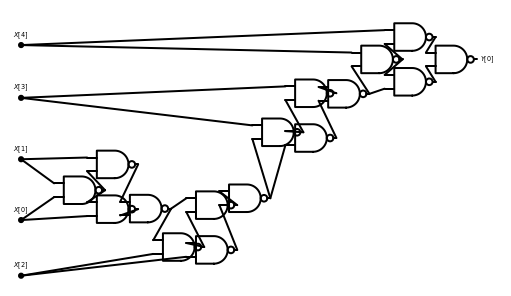

In [41]:
circuit(xor5)

In [42]:
CONSTPREFIX = r'''
temp = NAND(X[0],X[0])
one = NAND(X[0],temp)
zero = NAND(one,one)
'''[1:]

In [43]:
# "hardwire" an input x to a NAND program Q
# return Q' s.t. Q'(y)=Q(xy)
def hardwire(Q,x):
    n = len(x)
    for i in range(n): 
        Q = Q.replace(f'X[{i}]',('one' if x[i] else 'zero'))
    for i in range(n,2*len(Q)): 
        Q = Q.replace(f'X[{i}]',f'X[{i-n}]')
    return CONSTPREFIX+Q

In [ ]:
def indexat(t): return t

def unroll__(P,n,m,T):
    result = CONSTPREFIX
    for t in range(T // P.count('\n')):
        i = indexat(t) # value of i in T-th iteration
        valid = ('one' if i < n else 'zero' )
        inp   = ('X[i]' if i < n else 'zero')
        out   = ('Y[i]' if i < m else 'nonsense')
        result += P.replace('Xvalid[i]',valid).replace('X[i]',inp
                           ).replace('Y[i]',out).replace('[i]',f'[{i}]')
    return result

In [44]:
Q = hardwire(xor5,[1,0,1])
print(Q)

temp = NAND(X[0],X[0])
one = NAND(X[0],temp)
zero = NAND(one,one)
u   =  NAND(one,zero)
v   = NAND( one , u)
w   = NAND( zero , u)
s   = NAND( v   , w)
u   = NAND( s   , one)
v   = NAND( s   , u)
w   = NAND( one , u)
s   = NAND( v   , w)
u   = NAND( s   , X[0])
v   = NAND( s   , u)
w   = NAND( X[0] , u)
s   = NAND( v   , w)
u   = NAND( s   , X[1])
v   = NAND( s   , u)
w   = NAND( X[1] , u)
Y[0] = NAND( v   , w)



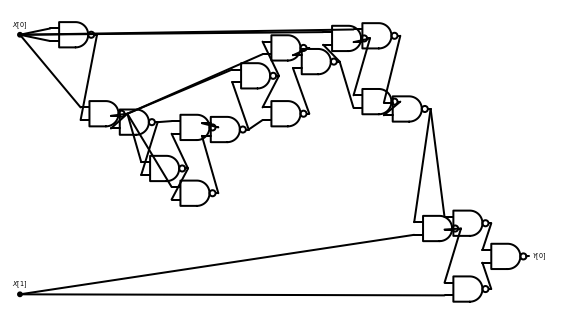

In [45]:
C = circuit(Q)
C

In [47]:
C(1,1)

0

## 3NAND

__Input:__ $\psi \in \{0,1\}^*$ representing 3NAND formula of form $(x_i = x_j NAND x_k) \wedge \cdots$

__Output:__ $1$ iff $\exists x\in \{0,1\}^*$ s.t. $\psi(x)=1$. 

In [48]:
Ψ = "(z0 = NAND(z2,z3) ) ∧ (z3 = NAND(z2,z1) ) ∧ (z1 = NAND(z2,z3) ) "

In [ ]:
# Evaluate 3CNAND Ψ on assignment x 
# Both are represented as strings
def eval3NAND(Ψ,x):

    def varval(v):
        return  int(x[int(v[1:])]) # assume vars are x_###
    
    for (v0,v1,v2) in getnandclauses(Ψ):
        if  varval(v0) != 1-varval(v1)*varval(v2): return False
    
    return True


In [ ]:

# Clause list of a 3CNF/3NAND formula  φ
def getcnfclauses(φ):
    clauses =  φ.split("∧")
    res = []
    for c in clauses:
        (v0,_,v1,_,v2) = c.strip()[1:-1].split()
        res.append((v0.strip(),v1.strip(),v2.strip()))
    return res

def getnandclauses(φ):
    clauses =  φ.split("∧")
    res = []
    for c in clauses:
        foo,bar,blah, = filter(None,re.split('\s*=\s*NAND\s*\(\s*|\s*\,\s*|\s*\)\s*|\s+',c.strip()[1:-1]))
        res.append((foo.strip(),bar.strip(),blah.strip()))
    return res



# number of variables of a formula φ
def numvars(φ):
    for n in range(len(φ)-1,0,-1):
        if φ.find(f'x{n}')>= 0 or φ.find(f'z{n}')>= 0: return n+1
    raise Exception


In [ ]:
getnandclauses(Ψ)

__Thm:__ $NANDSAT \leq_p 3NAND$

In [49]:
# Reduce NANDSAT to 3NAND
# Input: NAND prog Q
# Output: 3NAND formula Ψ
#        s.t. Ψ satisfiable iff Q is
def NANDSAT23NAND_(Q):
    # if Q doesn't start with CONSTPREFIX: Q = CONSTPREFIX + Q
    if Q[:len(CONSTPREFIX)] != CONSTPREFIX:
        Q = CONSTPREFIX + Q
    n, _  = numinout(Q)
    Ψ = ''

    #varidx[u] is n+line where u is last written to
    varidx = defaultdict(lambda : n+ 2) # line 2 corresponds to zero
    
    for i in range(n): varidx[f'X[{i}]'] = i # setup x_0...x_n-1
    
    j = n
    for line in Q.split('\n'):
        if not line.strip(): continue
        foo,_,bar,blah = parseline(line) # split "foo = NAND(bar,blah)"
        Ψ +=  f"(z{j} = NAND(z{varidx[bar]},z{varidx[blah]}) ) ∧ "
        varidx[foo] = j
        j += 1
    Ψ += f"(z{varidx['Y[0]']} = NAND(z{varidx['zero']},z{varidx['zero']}) )"
    return Ψ

In [ ]:
# Version of input above that keeps track of satisfying assignment y if given
#
# Reduce NANDSAT to 3NAND
# Input: NAND prog Q
# Output: 3NAND formula Ψ
#        s.t. Ψ satisfiable iff Q is
def NANDSAT23NAND(Q,y=[]):
    if Q[:len(CONSTPREFIX)] != CONSTPREFIX:
        Q = CONSTPREFIX + Q
    n, _  = numinout(Q)
    Ψ = ''
    z = defaultdict(int)

    #varidx[u] is n+line where u is last written to
    varidx = defaultdict(lambda : n+ 2) # line 2 corresponds to zero

    for i in range(n): 
        varidx[f'X[{i}]'] = i # setup x_0...x_n-1
        if y: z[i] = y[i]
    
    j = n
    for line in Q.split('\n'):
        if not line.strip(): continue
        foo,_,bar,blah = parseline(line)
        Ψ +=  f"(z{j} = NAND(z{varidx[bar]},z{varidx[blah]}) ) ∧ "
        if y: z[j] = NAND(z[varidx[bar]],z[varidx[blah]])
        varidx[foo] = j
        j += 1
    Ψ += f"(z{varidx['Y[0]']} = NAND(z{varidx['zero']},z{varidx['zero']}) )"
    return Ψ if not y else (Ψ,[z[i] for i in range(j)])

In [50]:
print(xor5) 
lines = xor5.count('\n')
n = max([i for i in range(2*lines) if xor5.find(f"X[{i}]")>=0])+1
print(f"Number of lines: {lines}, Number of variables: {n}")

u   =  NAND(X[0],X[1])
v   = NAND( X[0] , u)
w   = NAND( X[1] , u)
s   = NAND( v   , w)
u   = NAND( s   , X[2])
v   = NAND( s   , u)
w   = NAND( X[2] , u)
s   = NAND( v   , w)
u   = NAND( s   , X[3])
v   = NAND( s   , u)
w   = NAND( X[3] , u)
s   = NAND( v   , w)
u   = NAND( s   , X[4])
v   = NAND( s   , u)
w   = NAND( X[4] , u)
Y[0] = NAND( v   , w)

Number of lines: 16, Number of variables: 5


In [51]:
Ψ = NANDSAT23NAND_(xor5)
print(Ψ)
print(f"Vars: {numvars(Ψ)}, Clauses: {len(getnandclauses(Ψ))}")

(z5 = NAND(z0,z0) ) ∧ (z6 = NAND(z0,z5) ) ∧ (z7 = NAND(z6,z6) ) ∧ (z8 = NAND(z0,z1) ) ∧ (z9 = NAND(z0,z8) ) ∧ (z10 = NAND(z1,z8) ) ∧ (z11 = NAND(z9,z10) ) ∧ (z12 = NAND(z11,z2) ) ∧ (z13 = NAND(z11,z12) ) ∧ (z14 = NAND(z2,z12) ) ∧ (z15 = NAND(z13,z14) ) ∧ (z16 = NAND(z15,z3) ) ∧ (z17 = NAND(z15,z16) ) ∧ (z18 = NAND(z3,z16) ) ∧ (z19 = NAND(z17,z18) ) ∧ (z20 = NAND(z19,z4) ) ∧ (z21 = NAND(z19,z20) ) ∧ (z22 = NAND(z4,z20) ) ∧ (z23 = NAND(z21,z22) ) ∧ (z23 = NAND(z7,z7) )
Vars: 24, Clauses: 20


In [ ]:
z = NANDSAT23NAND(xor5,[1,0,0,1,1])[1]
z, len(z)

In [ ]:
eval3NAND(Ψ,z)

In [ ]:
z_ = list(z)
z_[2] = 1-z[2]
eval3NAND(Ψ,z_)

In [ ]:
Q = hardwire(xor5,[1,1])
(Ψ,y) = NANDSAT23NAND(Q,[1,1,1])
eval3NAND(Ψ,y)

## 3SAT 

__Input:__ 3CNF formula:  AND of $m$ _clauses_.   Clause = OR of three _literals_. Literal = variable or its negation.

__Goal:__ Output 1 iif formula _satisfiable_.

In [ ]:
φ = "(x0 ∨ ¬x3 ∨ x2 ) ∧ (¬x0 ∨ x1 ∨ ¬x2 ) ∧ (x1 ∨ x2 ∨ ¬x3 )  "

In [ ]:
# Evaluate 3CNF φ on assignment x 
# Both are represented as strings
def evalcnf(φ,x):

    def varval(v):
        return (1-x[int(v[2:])])  if v[0]=="¬" else x[int(v[1:])]
    
    for (v0,v1,v2) in getcnfclauses(φ):
        # print(c+str([varval(v0),varval(v1),varval(v2)]))
        if not varval(v0)+varval(v1)+varval(v2): return False
    
    return True

# Clause list of a 3CNF φ
def getcnfclauses(φ):
    clauses =  φ.split("∧")
    res = []
    for c in clauses:
        (v0,_,v1,_,v2) = c.strip()[1:-1].split()
        res.append((v0.strip(),v1.strip(),v2.strip()))
    return res

In [ ]:
numvars(φ)

__Thm:__ $3NAND \leq_p 3SAT$

__Proof:__ $a = NAND(b,c)$   iff  $(\neg a \vee \neg b \vee \neg c) \wedge (a \vee b) \wedge (a \vee c)$

In [52]:
# Reduce 3NAND to 3SAT
# Input: 3NAND formula Ψ
# Output: 3CNF formula φ
#        s.t.  φ satisfiable iff Ψ is
def NAND23SAT_(Ψ):
    φ = ""
    for (a,b,c) in getnandclauses(Ψ):
        φ += f'(¬{a} ∨ ¬{b} ∨ ¬{c}) ∧ ({a} ∨ {b}  ∨ {b}) ∧ ({a}  ∨  {c} ∨ {c}) ∧ '
    return φ[:-3] # chop off redundant ∧

In [53]:
Ψ = "(x0 = NAND(x2,x3) ) ∧ (x3 = NAND(x2,x1) ) ∧ (x1 = NAND(x2,x3) ) "
NAND23SAT_(Ψ)

'(¬x0 ∨ ¬x2 ∨ ¬x3) ∧ (x0 ∨ x2  ∨ x2) ∧ (x0  ∨  x3 ∨ x3) ∧ (¬x3 ∨ ¬x2 ∨ ¬x1) ∧ (x3 ∨ x2  ∨ x2) ∧ (x3  ∨  x1 ∨ x1) ∧ (¬x1 ∨ ¬x2 ∨ ¬x3) ∧ (x1 ∨ x2  ∨ x2) ∧ (x1  ∨  x3 ∨ x3)'

In [ ]:
# Same as above but keeping track of assignment
def NAND23SAT(Ψ,y=[]):
    φ = ""
    def makex(a): return "x"+a[1:]
    for (a,b,c) in getnandclauses(Ψ):
        a = makex(a)
        b = makex(b)
        c = makex(c)
        φ += f'(¬{a} ∨ ¬{b} ∨ ¬{c}) ∧ ({a} ∨ {b}  ∨ {b}) ∧ ({a}  ∨  {c} ∨ {c}) ∧ '
    return (φ[:-3],y) if y else φ[:-3] # chop off redundant ∧

In [54]:
φ = NAND23SAT(NANDSAT23NAND(Q))
print(φ)

(¬x2 ∨ ¬x0 ∨ ¬x0) ∧ (x2 ∨ x0  ∨ x0) ∧ (x2  ∨  x0 ∨ x0) ∧ (¬x3 ∨ ¬x0 ∨ ¬x2) ∧ (x3 ∨ x0  ∨ x0) ∧ (x3  ∨  x2 ∨ x2) ∧ (¬x4 ∨ ¬x3 ∨ ¬x3) ∧ (x4 ∨ x3  ∨ x3) ∧ (x4  ∨  x3 ∨ x3) ∧ (¬x5 ∨ ¬x3 ∨ ¬x4) ∧ (x5 ∨ x3  ∨ x3) ∧ (x5  ∨  x4 ∨ x4) ∧ (¬x6 ∨ ¬x3 ∨ ¬x5) ∧ (x6 ∨ x3  ∨ x3) ∧ (x6  ∨  x5 ∨ x5) ∧ (¬x7 ∨ ¬x4 ∨ ¬x5) ∧ (x7 ∨ x4  ∨ x4) ∧ (x7  ∨  x5 ∨ x5) ∧ (¬x8 ∨ ¬x6 ∨ ¬x7) ∧ (x8 ∨ x6  ∨ x6) ∧ (x8  ∨  x7 ∨ x7) ∧ (¬x9 ∨ ¬x8 ∨ ¬x3) ∧ (x9 ∨ x8  ∨ x8) ∧ (x9  ∨  x3 ∨ x3) ∧ (¬x10 ∨ ¬x8 ∨ ¬x9) ∧ (x10 ∨ x8  ∨ x8) ∧ (x10  ∨  x9 ∨ x9) ∧ (¬x11 ∨ ¬x3 ∨ ¬x9) ∧ (x11 ∨ x3  ∨ x3) ∧ (x11  ∨  x9 ∨ x9) ∧ (¬x12 ∨ ¬x10 ∨ ¬x11) ∧ (x12 ∨ x10  ∨ x10) ∧ (x12  ∨  x11 ∨ x11) ∧ (¬x13 ∨ ¬x12 ∨ ¬x0) ∧ (x13 ∨ x12  ∨ x12) ∧ (x13  ∨  x0 ∨ x0) ∧ (¬x14 ∨ ¬x12 ∨ ¬x13) ∧ (x14 ∨ x12  ∨ x12) ∧ (x14  ∨  x13 ∨ x13) ∧ (¬x15 ∨ ¬x0 ∨ ¬x13) ∧ (x15 ∨ x0  ∨ x0) ∧ (x15  ∨  x13 ∨ x13) ∧ (¬x16 ∨ ¬x14 ∨ ¬x15) ∧ (x16 ∨ x14  ∨ x14) ∧ (x16  ∨  x15 ∨ x15) ∧ (¬x17 ∨ ¬x16 ∨ ¬x1) ∧ (x17 ∨ x16  ∨ x16) ∧ (x17  ∨  x1 ∨ x1) ∧ (¬x18 ∨ ¬x16 ∨ ¬x17) ∧ (x18 ∨ x16  ∨ 

In [ ]:
# Reduction φ ↦ G
def SAT2IS_(φ):
    n = numvars(φ) 
    G =Graph(engine='neato')
    
    # add pairs "x_i=0" and "x_i=1"
    for i in range(n): G.edge(f'x_{i}=0',f'x_{i}=1')
        
    # map "x_7" with index 5 to "5)x_7≠0", "¬x_12" with index 6 to "6)x_12≠1"
    def nodename(v,c): return str(c)+')'+(v[1:]+"≠1" if v[0]=="¬" else v+"≠0")
    
    #map "5)x_7≠0" to its neighbor "x_7=0"
    def neighbor(n):   return n.split(')')[1].split('≠')[0]+"="+n[-1]
    
    c = 0
    for C in getcnfclauses(φ):
        (u,v,w) = (nodename(C[0],c),nodename(C[1],c+1),nodename(C[2],c+2))
        
        # add triangle of clause
        G.edges([(u,v),(v,w),(u,w)])
        
        # connect each vertex to inconsistent neighbor
        G.edges([(u,neighbor(u)),(v,neighbor(v)),(w,neighbor(w))])
        c += 3
    
    return G

In [ ]:
# same reduction but taking care of colors and keeping track what happens to an assignment
def SAT2IS(φ,x=""):
    S = []
#    G.node(u,style='filled',fillcolor=('red' if x and x[i]=="0" else 'green'))
        
    n = numvars(φ) 
    G =Graph() # (engine='neato')
    
    def nname(c,v): return f"({c},{v})"
    
    c = 0
    nodes = {}
    for i in range(n):
        nodes["x"+str(i)] = []
        nodes["¬x"+str(i)] = []
    
    for C in getcnfclauses(φ):
        sat = False
        for u in C: 
            if x and (not sat) and (((u[0]=="¬") and (x[int(u[2:])]=="0")) or ((u[0]!="¬") and (x[int(u[1:])]=="1"))):
                G.node(nname(c,u),f"{c},{subscript(u)}",fontsize="10",style='filled',fillcolor='green')
                S.append(nname(c,u))
                sat = True
            else:
                G.node(nname(c,u),f"{c},{subscript(u)}",fontsize="10")
            negu = u[1:] if u[0]=="¬" else "¬"+u
            for v in nodes[negu]: G.edge(nname(c,u),v,color="red") 
            nodes[u].append(nname(c,u))
        G.edges([[nname(c,C[0]), nname(c,C[1])],[nname(c,C[1]), nname(c,C[2])],[nname(c,C[0]), nname(c,C[2])]])
        c += 1
    
    return (scale(G) if not x else (scale(G),S))

In [ ]:
# same reduction as above but handling colors and showing the resulting cut when the original graph has independent set
def IS2MAXCUT(G,I=[]):
    G =nxgraph(G)
    S = []
    H =Graph() # engine='sfdp')
    H.node("source",style='filled',fillcolor='blue')
    S.append("source")
    for v in G.nodes():
        color = ('red' if I and v in I else 'lightblue')
        H.node(v,label=subscript(v),fontsize="10",style='filled',fillcolor=color, shape="square")
        ecol = 'black'
        pwidth = '1'
        if I and v in I: 
            S.append(v)
            ecol = 'red'
            pwidth = '2'
        H.edge("source",v,color=ecol,penwidth=pwidth)  # len="2"
    
    j =0
    for (u,v) in G.edges():
        g1 = "e"+str(j)+"a"
        g2 = "e"+str(j)+"b"
        c1 = 'green'
        c2 = 'green'
        if I and (not u in I):
            c1 = 'red'
            S.append(g1)
        if I and (not v in I):
            c2 = 'red'
            S.append(g2)
        gadget = Graph("gadget"+str(j))
        gadget.node(g1,subscript("e0"),fontsize="10",style='filled',fillcolor=c1)
        gadget.node(g2,subscript("e1"),fontsize="10",style='filled',fillcolor=c2)
        gadget.edge(g1,g2,color=('red' if (g1 in S) != (g2 in I) else 'black'), penwidth=('2' if (g1 in S) != (g2 in I) else '1')) # len="1"
        gadget.edge(u,g1, color=('red' if (g1 in S) != (u in I) else 'black'),penwidth =('2' if (g1 in S) != (u in S) else '1')  ) # len="1"
        gadget.edge(v,g2, color=('red' if (g2 in S) != (v in I) else 'black'),penwidth= ('2' if (g2 in S) != (v in S) else '1') ) # len="1"
        
        H.subgraph(gadget)
        H.edge(g1,"source",color=('red' if (g1 in S)  else 'black'),penwidth=('2' if (g1 in S)  else '1')) # len="2.5"
        H.edge(g2,"source",color=('red' if (g2 in S)  else 'black'),penwidth= ('2' if (g2 in S)  else '1') )
        j +=1
        
    
    return (scale(H),S) if I else scale(H)

## Putting everything together

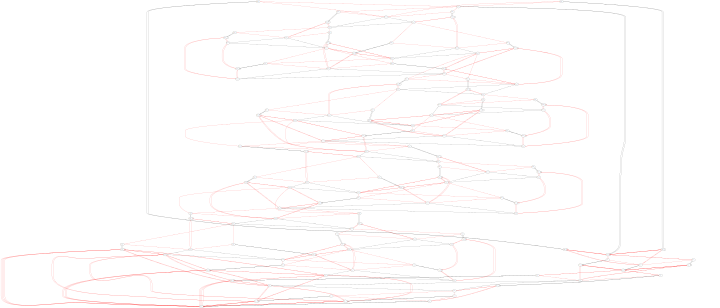

In [38]:
SAT2IS(*NAND23SAT(*NANDSAT23NAND(xor5,(1,0,1,0,1))))[0]

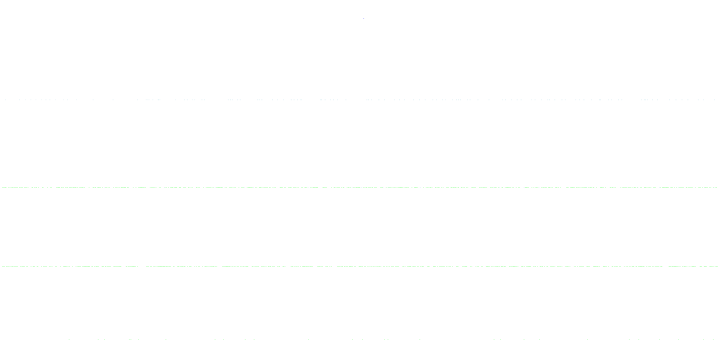

In [39]:
IS2MAXCUT(SAT2IS(NAND23SAT(NANDSAT23NAND(xor5))))